### Cloning [**simplif-ai**](https://github.com/namanshrimali/simplif-ai.git)
A library which have all the boilerplate codes available as a module, a one stop solution to jump start deep learning 

In [1]:
!git clone https://github.com/namanshrimali/simplif-ai.git
!pip install -U albumentations
%cd simplif-ai

%matplotlib inline 
# This turns on inline plotting, where plot graphics will appear in notebook.

fatal: destination path 'simplif-ai' already exists and is not an empty directory.
Requirement already up-to-date: albumentations in c:\users\naman\miniconda3\envs\aipy\lib\site-packages (0.5.2)
c:\Users\naman\Desktop\TSAI_EVA\simplif-ai


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
from util.devices import find_device
from data_action.data_loader import *
from util.mean_std_calc import calc_mean_std
from util.seed import seed_everything

seed_everything()

device = find_device()
BATCH_SIZE = 128
DATASET = 'CIFAR10' 
mean, std = (0.49139884, 0.48215783, 0.44653153), (0.20230089, 0.19941294, 0.200962)
# mean, std = calc_mean_std(DATASET) # calculates mean and standard deviation of the dataset

data_loader = Data_Loader(device, BATCH_SIZE, dataset = DATASET, mean = mean, std = std, transform_type='common')

trainloader = data_loader.load_training_data()
testloader = data_loader.load_testing_data()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

target_layers = ["layer1", "layer2", "layer3", "layer4"] # for gradcam


device: cuda

Loading training data. Dataset: CIFAR10
Files already downloaded and verified
Training data loaded

Loading testing data.
Files already downloaded and verified
Test data loaded



Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

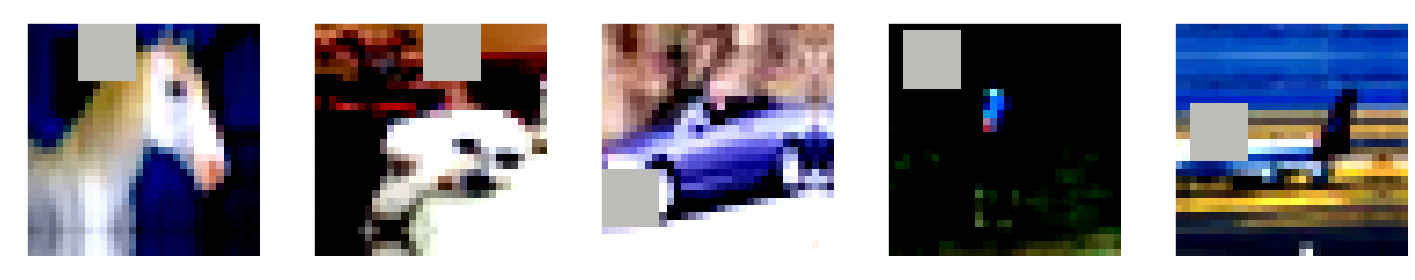

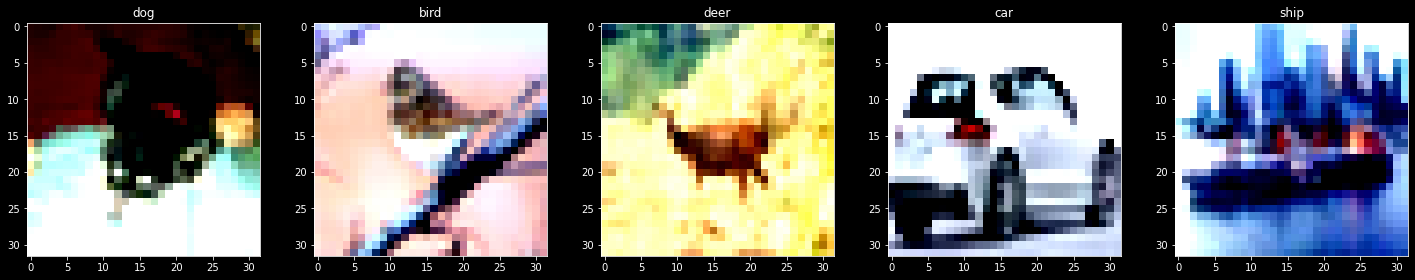

In [3]:
from util.image_plot import plot_images

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)

# get some random testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
from model.modified_resnet import ResNet18 # using modified resnet

model = ResNet18(0.0).to(device) # configuring 0% dropout in the resnet-18

### Model summary

In [5]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
          Dropout-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

## Training model
> * finding optimal learning rate
> * defining Stochastic Gradient Descent as optimizer
---





### Defining optimizer and scheduler

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

### Finding optimal learning rate

100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.05E-02


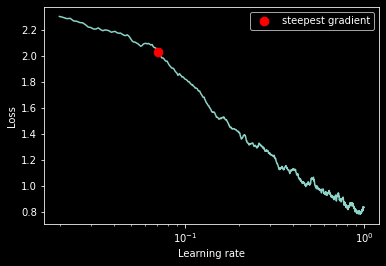

In [7]:
from analytics.lr_finder.finder_util import find_me_ideal_lr

ideal_lr = find_me_ideal_lr(model, optimizer, criterion, trainloader, device, plot_graph = True, num_iter = 1000, step_mode = "linear")

### Setting optimal learning rate


In [8]:
  EPOCHS = 24
  MAX_AT_EPOCH = 5
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer= optimizer, epochs=EPOCHS, steps_per_epoch = len(trainloader), pct_start=MAX_AT_EPOCH/EPOCHS, max_lr = ideal_lr, div_factor= 8., final_div_factor=.9, verbose=False)

In [9]:
from learning.train import train
from learning.validate import test

train_loss = [] 
train_accuracy = []
test_loss = []
test_accuracy = []
learning_rates = []


for epoch in range(EPOCHS):  # loop over the dataset multiple times
    misclassified = []
    print(f'Epoch: {epoch+1}')
    train(model, device, trainloader, train_loss, train_accuracy, optimizer, learning_rates, scheduler)
    val_loss = test(model, device, testloader, test_loss, test_accuracy, misclassified)

loss=1.2181693315505981 batch_id=390: 100%|██████████| 391/391 [01:24<00:00,  4.64it/s]
\Train set: Accuracy: 26256/50000 (52.5120%)

  0%|          | 0/391 [00:00<?, ?it/s]
Test set: Average loss: 1.0793, Accuracy: 6224/10000 (62.24%)

Epoch: 2
loss=1.0795717239379883 batch_id=390: 100%|██████████| 391/391 [01:26<00:00,  4.50it/s]
\Train set: Accuracy: 34320/50000 (68.6400%)

  0%|          | 0/391 [00:00<?, ?it/s]
Test set: Average loss: 0.7750, Accuracy: 7264/10000 (72.64%)

Epoch: 3
loss=0.8189433217048645 batch_id=390: 100%|██████████| 391/391 [01:27<00:00,  4.49it/s]
\Train set: Accuracy: 37773/50000 (75.5460%)

  0%|          | 0/391 [00:00<?, ?it/s]
Test set: Average loss: 0.6924, Accuracy: 7654/10000 (76.54%)

Epoch: 4
loss=0.7203024625778198 batch_id=390: 100%|██████████| 391/391 [01:27<00:00,  4.47it/s]
\Train set: Accuracy: 39710/50000 (79.4200%)

  0%|          | 0/391 [00:00<?, ?it/s]
Test set: Average loss: 0.5741, Accuracy: 8020/10000 (80.20%)

Epoch: 5
loss=0.539794862

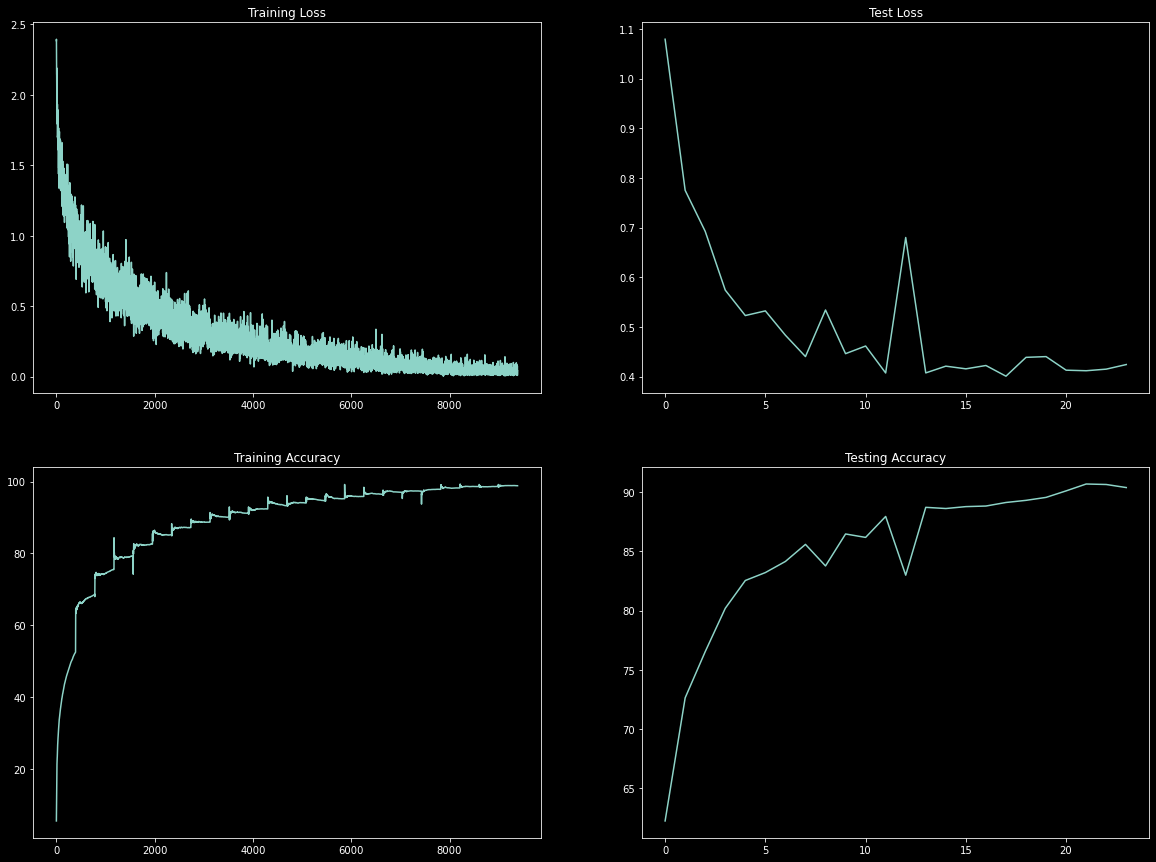

In [10]:
from util.graph_plot import plot_me
plot_me(train_loss, train_accuracy, test_loss, test_accuracy)

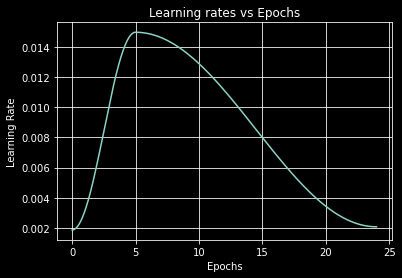

In [11]:
import numpy
from util.graph_plot import plot_graph

x_plots  = np.arange(0, EPOCHS, 1/len(trainloader))
plot_graph((x_plots, learning_rates), 'Learning rates vs Epochs', ('Epochs', 'Learning Rate'), False)